In [1]:
import numpy as np
import os
import nibabel as nib
import glob
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler() 

In [4]:
TRAIN_DATASET_PATH = 'GLIOMA/'
#VALIDATION_DATASET_PATH = 'BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData'

test_image_flair=nib.load(TRAIN_DATASET_PATH + 'BraTS-GLI-00008-000/BraTS-GLI-00008-000-t2f.nii.gz').get_fdata()
print(test_image_flair.max())
#Scalers are applied to 1D so let us reshape and then reshape back to original shape. 
test_image_flair=scaler.fit_transform(test_image_flair.reshape(-1, test_image_flair.shape[-1])).reshape(test_image_flair.shape)


test_image_t1=nib.load(TRAIN_DATASET_PATH + 'BraTS-GLI-00008-000/BraTS-GLI-00008-000-t1n.nii.gz').get_fdata()
test_image_t1=scaler.fit_transform(test_image_t1.reshape(-1, test_image_t1.shape[-1])).reshape(test_image_t1.shape)

test_image_t1ce=nib.load(TRAIN_DATASET_PATH + 'BraTS-GLI-00008-000/BraTS-GLI-00008-000-t1c.nii.gz').get_fdata()
test_image_t1ce=scaler.fit_transform(test_image_t1ce.reshape(-1, test_image_t1ce.shape[-1])).reshape(test_image_t1ce.shape)

test_image_t2=nib.load(TRAIN_DATASET_PATH + 'BraTS-GLI-00008-000/BraTS-GLI-00008-000-t2w.nii.gz').get_fdata()
test_image_t2=scaler.fit_transform(test_image_t2.reshape(-1, test_image_t2.shape[-1])).reshape(test_image_t2.shape)

test_mask=nib.load(TRAIN_DATASET_PATH + 'BraTS-GLI-00008-000/BraTS-GLI-00008-000-seg.nii.gz').get_fdata()
test_mask=test_mask.astype(np.uint8)

print(np.unique(test_mask))


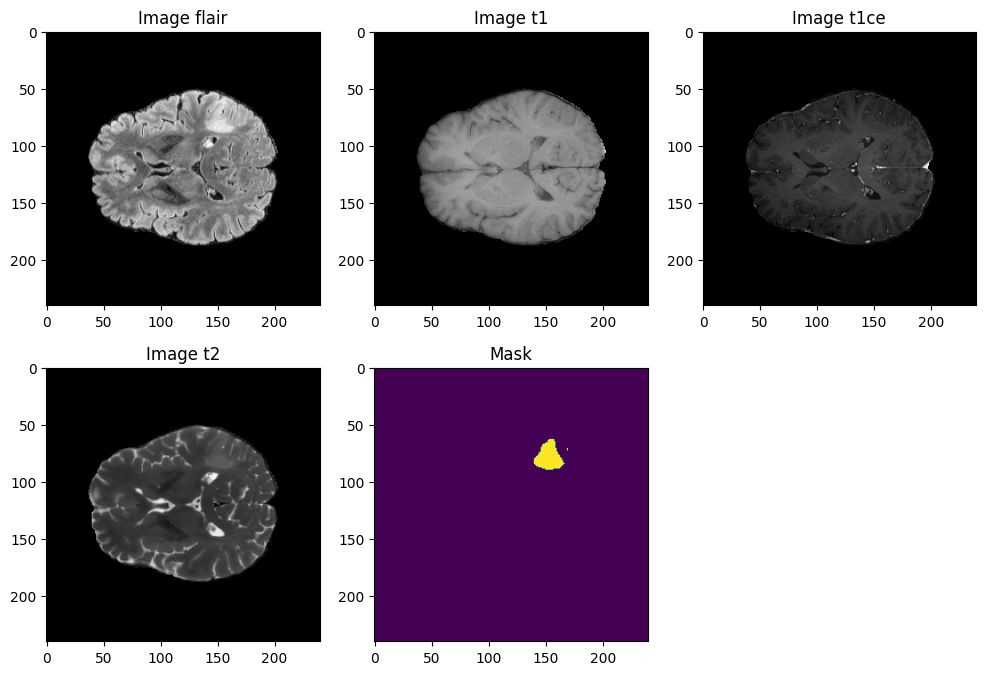

In [11]:
import random
n_slice=random.randint(0, test_mask.shape[2])

plt.figure(figsize=(12, 8))

plt.subplot(231)
plt.imshow(test_image_flair[:,:,n_slice], cmap='gray')
plt.title('Image flair')
plt.subplot(232)
plt.imshow(test_image_t1[:,:,n_slice], cmap='gray')
plt.title('Image t1')
plt.subplot(233)
plt.imshow(test_image_t1ce[:,:,n_slice], cmap='gray')
plt.title('Image t1ce')
plt.subplot(234)
plt.imshow(test_image_t2[:,:,n_slice], cmap='gray')
plt.title('Image t2')
plt.subplot(235)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

In [13]:
import numpy as np
from scipy.ndimage import zoom

# Apilar las imágenes en una nueva dimensión
combined_x = np.stack([test_image_flair, test_image_t1ce, test_image_t2, test_image_t1], axis=3)

# Asegúrate de que las dimensiones son correctas antes de redimensionar
print(f"Dimensiones: {combined_x.shape}")

Dimensiones: (240, 240, 155, 4)


In [15]:
import glob
import numpy as np
import nibabel as nib
from collections import Counter
import pandas as pd
import plotly.express as px

# Listas de archivos
mask_list = sorted(glob.glob('GLIOMA/*/*seg.nii.gz'))

# Contador de frecuencias de máscaras que contienen cada clase
class_presence_counts = Counter()

for img in range(len(mask_list)):  # Iterar sobre las máscaras
    print(f"Now processing mask number: {img}")
    
    # Cargar la máscara
    temp_mask = nib.load(mask_list[img]).get_fdata()
    temp_mask = temp_mask.astype(np.uint8)
    
    # Verificar presencia de cada clase
    unique_classes = np.unique(temp_mask)
    class_presence_counts.update(unique_classes)

# Convertir el contador a un DataFrame
df = pd.DataFrame(list(class_presence_counts.items()), columns=['Class', 'Frequency'])

# Guardar el DataFrame en un archivo CSV
df.to_csv('class_presence_frequencies.csv', index=False)

# Crear gráfico interactivo
fig = px.bar(df, x='Class', y='Frequency', title='Presence of Classes in NIfTI Masks',
             labels={'Class': 'Class', 'Frequency': 'Number of Masks'},
             hover_data=['Frequency'])

fig.show()


Now processing mask number: 0
Now processing mask number: 1
Now processing mask number: 2
Now processing mask number: 3
Now processing mask number: 4
Now processing mask number: 5
Now processing mask number: 6
Now processing mask number: 7
Now processing mask number: 8
Now processing mask number: 9
Now processing mask number: 10
Now processing mask number: 11
Now processing mask number: 12
Now processing mask number: 13
Now processing mask number: 14
Now processing mask number: 15
Now processing mask number: 16
Now processing mask number: 17
Now processing mask number: 18
Now processing mask number: 19
Now processing mask number: 20
Now processing mask number: 21
Now processing mask number: 22
Now processing mask number: 23
Now processing mask number: 24
Now processing mask number: 25
Now processing mask number: 26
Now processing mask number: 27
Now processing mask number: 28
Now processing mask number: 29
Now processing mask number: 30
Now processing mask number: 31
Now processing mas

In [3]:
import numpy as np
import nibabel as nib
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.utils import to_categorical
from skimage.transform import resize
import h5py
import glob

# Listas de archivos
t1_list = sorted(glob.glob('GLIOMAS/*/*t1n.nii.gz'))
t2_list = sorted(glob.glob('GLIOMAS/*/*t2W.nii.gz'))
t1ce_list = sorted(glob.glob('GLIOMAS/*/*t1c.nii.gz'))
flair_list = sorted(glob.glob('GLIOMAS/*/*t2f.nii.gz'))
mask_list = sorted(glob.glob('GLIOMAS/*/*seg.nii.gz'))

scaler = MinMaxScaler()
target_shape = (128, 128, 128)  # Dimensiones objetivo

for img in range(len(t1ce_list)):  # Usando t1ce_list ya que todas las listas tienen el mismo tamaño
    print("Now preparing image and masks number: ", img)
    
    temp_image_t1 = nib.load(t1_list[img]).get_fdata()
    temp_image_t1 = scaler.fit_transform(temp_image_t1.reshape(-1, temp_image_t1.shape[-1])).reshape(temp_image_t1.shape)

    temp_image_t2 = nib.load(t2_list[img]).get_fdata()
    temp_image_t2 = scaler.fit_transform(temp_image_t2.reshape(-1, temp_image_t2.shape[-1])).reshape(temp_image_t2.shape)
    
    # Cargar y normalizar imágenes
    temp_image_t1ce = nib.load(t1ce_list[img]).get_fdata()
    temp_image_t1ce = scaler.fit_transform(temp_image_t1ce.reshape(-1, temp_image_t1ce.shape[-1])).reshape(temp_image_t1ce.shape)
   
    temp_image_flair = nib.load(flair_list[img]).get_fdata()
    temp_image_flair = scaler.fit_transform(temp_image_flair.reshape(-1, temp_image_flair.shape[-1])).reshape(temp_image_flair.shape)
        
    temp_mask = nib.load(mask_list[img]).get_fdata()
    temp_mask = temp_mask.astype(np.uint8)
    
    temp_combined_images = np.stack([ temp_image_t1ce, temp_image_t2, temp_image_flair], axis=3)
    
    # Redimensionar a las dimensiones deseadas
    temp_combined_images_resized = resize(temp_combined_images, target_shape, mode='constant', anti_aliasing=True)
    temp_mask_resized = resize(temp_mask, target_shape, mode='constant', anti_aliasing=False, preserve_range=True).astype(np.uint8)
    
    # Verificar y guardar
    val, counts = np.unique(temp_mask_resized, return_counts=True)
    temp_mask_resized = to_categorical(temp_mask_resized, num_classes=4)

    # Guardar en un único archivo HDF5
    with h5py.File(f'C:/Users/lcres/Desktop/modelo/patient_{img}.h5', 'w') as hf:
        hf.create_dataset('images', data=temp_combined_images_resized, compression='gzip')
        hf.create_dataset('masks', data=temp_mask_resized, compression='gzip')
    
    print(f"imagenes y mascaras guardas con numero de paciente {img} como HDF5 ")


Now preparing image and masks number:  0
imagenes y mascaras guardas con numero de paciente 0 como HDF5 
Now preparing image and masks number:  1
imagenes y mascaras guardas con numero de paciente 1 como HDF5 
Now preparing image and masks number:  2
imagenes y mascaras guardas con numero de paciente 2 como HDF5 
Now preparing image and masks number:  3
imagenes y mascaras guardas con numero de paciente 3 como HDF5 
Now preparing image and masks number:  4
imagenes y mascaras guardas con numero de paciente 4 como HDF5 


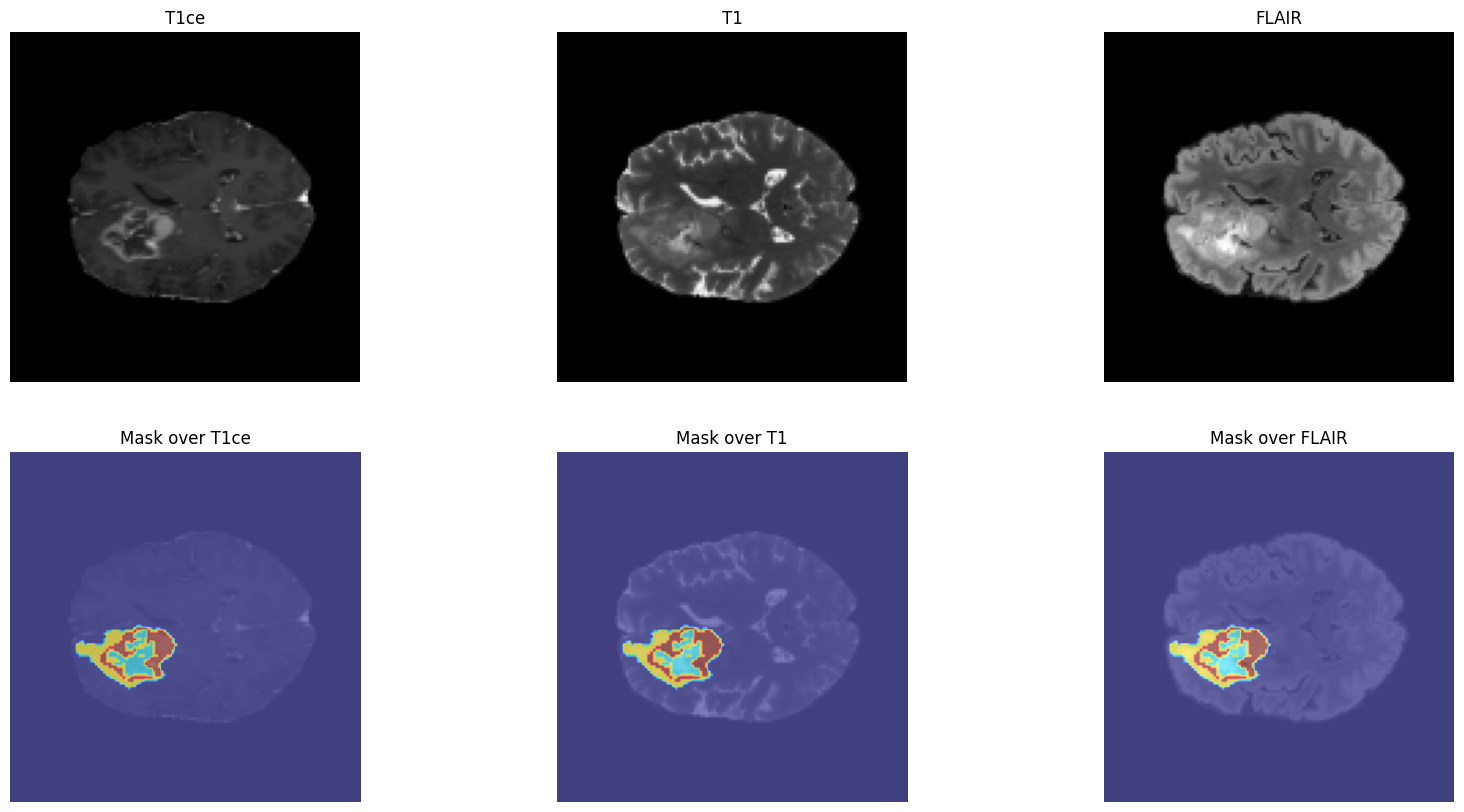

In [27]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

# Función para cargar datos de un archivo HDF5
def load_hdf5_file(file_path):
    with h5py.File(file_path, 'r') as hf:
        images_sequence = hf['images'][:]
        masks_sequence = hf['masks'][:]
    return images_sequence, masks_sequence

# Cargar el archivo HDF5
file_path = 'C:/Users/lcres/Desktop/modelo/patient_0.h5'
images_sequence, masks_sequence = load_hdf5_file(file_path)

# Seleccionar una rebanada del eje z (por ejemplo, la rebanada en el medio)
z_slice = 64

# Crear un subplot de 2 filas y 4 columnas
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
modalities = [ 'T1ce', 'T1', 'FLAIR']

# Visualizar las 4 modalidades de imagen en la primera fila
for i in range(3):
    axes[0, i].imshow(images_sequence[:, :, z_slice, i], cmap='gray')
    axes[0, i].set_title(modalities[i])
    axes[0, i].axis('off')

# Visualizar las máscaras correspondientes en la segunda fila
# Aquí visualizamos todas las clases de la máscara superpuestas
combined_mask = np.argmax(masks_sequence[:, :, z_slice], axis=-1)
for i in range(3):
    axes[1, i].imshow(images_sequence[:, :, z_slice, i], cmap='gray', alpha=0.5)
    axes[1, i].imshow(combined_mask, cmap='jet', alpha=0.5)
    axes[1, i].set_title(f'Mask over {modalities[i]}')
    axes[1, i].axis('off')

plt.show()


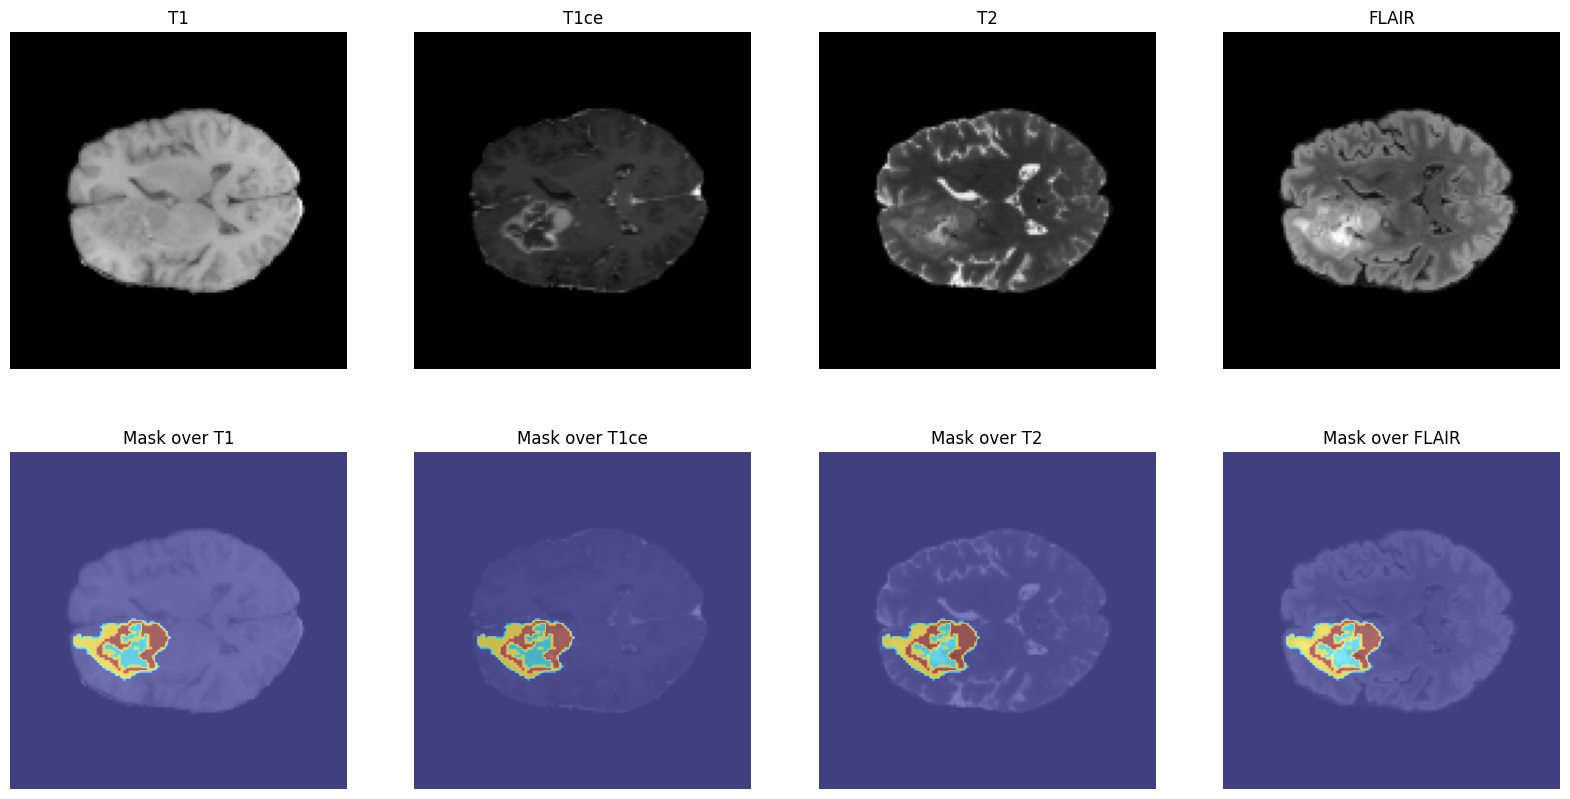

In [24]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

# Función para cargar datos de un archivo HDF5
def load_hdf5_file(file_path):
    with h5py.File(file_path, 'r') as hf:
        images_sequence = hf['images'][:]
        masks_sequence = hf['masks'][:]
    return images_sequence, masks_sequence

# Cargar el archivo HDF5
file_path = 'C:/Users/lcres/Downloads/patient_0.h5 (1)/patient_0.h5'
images_sequence, masks_sequence = load_hdf5_file(file_path)

# Seleccionar una rebanada del eje z (por ejemplo, la rebanada en el medio)
z_slice = 64

# Crear un subplot de 2 filas y 4 columnas
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
modalities = ['T1', 'T1ce', 'T2', 'FLAIR']

# Visualizar las 4 modalidades de imagen en la primera fila
for i in range(4):
    axes[0, i].imshow(images_sequence[:, :, z_slice, i], cmap='gray')
    axes[0, i].set_title(modalities[i])
    axes[0, i].axis('off')

# Visualizar las máscaras correspondientes en la segunda fila
# Aquí visualizamos todas las clases de la máscara superpuestas
combined_mask = np.argmax(masks_sequence[:, :, z_slice], axis=-1)
for i in range(4):
    axes[1, i].imshow(images_sequence[:, :, z_slice, i], cmap='gray', alpha=0.5)
    axes[1, i].imshow(combined_mask, cmap='jet', alpha=0.5)
    axes[1, i].set_title(f'Mask over {modalities[i]}')
    axes[1, i].axis('off')

plt.show()


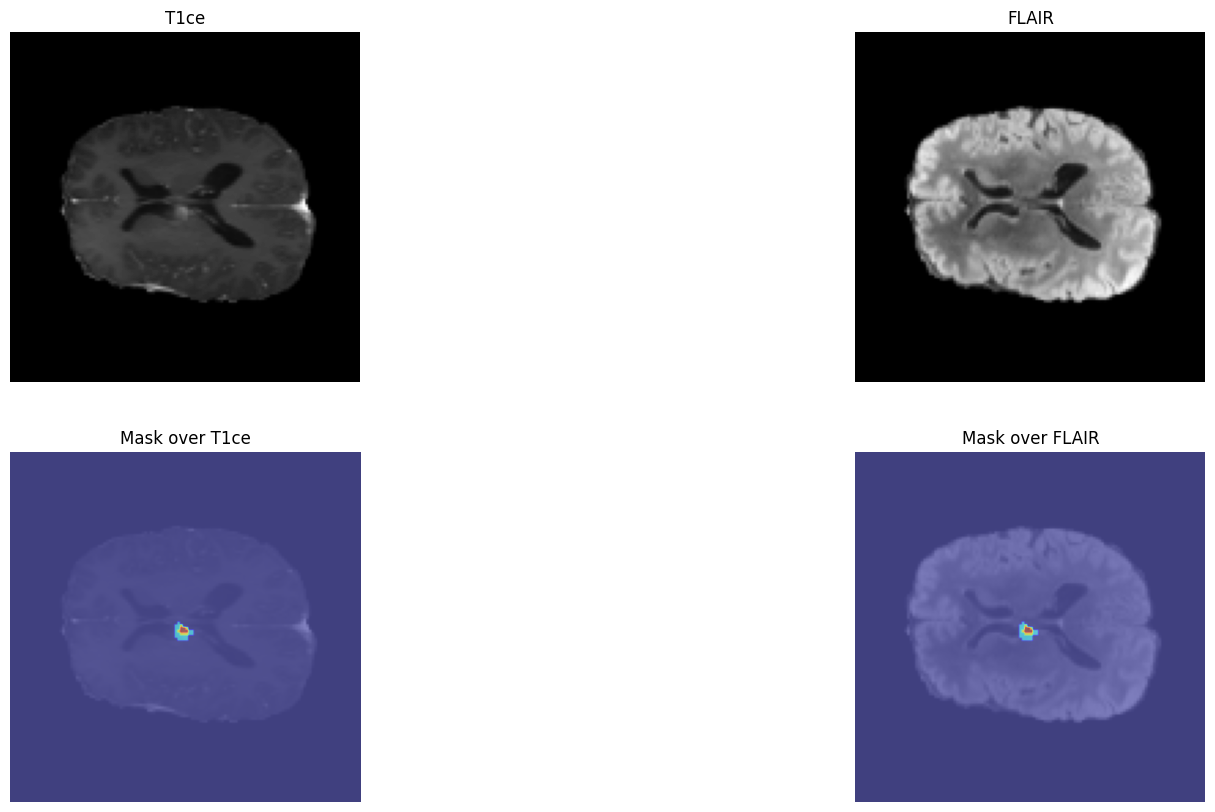

In [23]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

# Función para cargar datos de un archivo HDF5
def load_hdf5_file(file_path):
    with h5py.File(file_path, 'r') as hf:
        images_sequence = hf['images'][:]
        masks_sequence = hf['masks'][:]
    return images_sequence, masks_sequence

# Cargar el archivo HDF5
file_path = 'C:/Users/lcres/Desktop/modelo/patient_0.h5'
images_sequence, masks_sequence = load_hdf5_file(file_path)

# Seleccionar una rebanada del eje z (por ejemplo, la rebanada en el medio)
z_slice = 64

# Crear un subplot de 2 filas y 4 columnas
fig, axes = plt.subplots(2, 2, figsize=(20, 10))
modalities = [ 'T1ce', 'FLAIR']

# Visualizar las 4 modalidades de imagen en la primera fila
for i in range(2):
    axes[0, i].imshow(images_sequence[:, :, z_slice, i], cmap='gray')
    axes[0, i].set_title(modalities[i])
    axes[0, i].axis('off')

# Visualizar las máscaras correspondientes en la segunda fila
# Aquí visualizamos todas las clases de la máscara superpuestas
combined_mask = np.argmax(masks_sequence[:, :, z_slice], axis=-1)
for i in range(2):
    axes[1, i].imshow(images_sequence[:, :, z_slice, i], cmap='gray', alpha=0.5)
    axes[1, i].imshow(combined_mask, cmap='jet', alpha=0.5)
    axes[1, i].set_title(f'Mask over {modalities[i]}')
    axes[1, i].axis('off')

plt.show()


In [3]:
import numpy as np
import nibabel as nib
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.utils import to_categorical
from skimage.transform import resize
import h5py
import glob

# Listas de archivos

t2_list = sorted(glob.glob('GLIOMA/*/*t2W.nii.gz'))
t1ce_list = sorted(glob.glob('GLIOMA/*/*t1c.nii.gz'))
flair_list = sorted(glob.glob('GLIOMA/*/*t2f.nii.gz'))
mask_list = sorted(glob.glob('GLIOMA/*/*seg.nii.gz'))

scaler = MinMaxScaler()
target_shape = (128, 128, 128)  # Dimensiones objetivo

for img in range(len(t1ce_list)):  # Usando t1ce_list ya que todas las listas tienen el mismo tamaño
    print("Now preparing image and masks number: ", img)
    

    temp_image_t2 = nib.load(t2_list[img]).get_fdata()
    temp_image_t2 = scaler.fit_transform(temp_image_t2.reshape(-1, temp_image_t2.shape[-1])).reshape(temp_image_t2.shape)
    
    # Cargar y normalizar imágenes
    temp_image_t1ce = nib.load(t1ce_list[img]).get_fdata()
    temp_image_t1ce = scaler.fit_transform(temp_image_t1ce.reshape(-1, temp_image_t1ce.shape[-1])).reshape(temp_image_t1ce.shape)
   
    temp_image_flair = nib.load(flair_list[img]).get_fdata()
    temp_image_flair = scaler.fit_transform(temp_image_flair.reshape(-1, temp_image_flair.shape[-1])).reshape(temp_image_flair.shape)
        
    temp_mask = nib.load(mask_list[img]).get_fdata()
    temp_mask = temp_mask.astype(np.uint8)
    
    temp_combined_images = np.stack([ temp_image_t1ce, temp_image_t2, temp_image_flair], axis=3)
    
    # Redimensionar a las dimensiones deseadas
    temp_combined_images_resized = resize(temp_combined_images, target_shape, mode='constant', anti_aliasing=True)
    temp_mask_resized = resize(temp_mask, target_shape, mode='constant', anti_aliasing=False, preserve_range=True).astype(np.uint8)
    
    # Verificar y guardar
    val, counts = np.unique(temp_mask_resized, return_counts=True)
    temp_mask_resized = to_categorical(temp_mask_resized, num_classes=4)

    # Guardar en un único archivo HDF5
    with h5py.File(f'C:/Users/lcres/Desktop/modelo/patient_{img}.h5', 'w') as hf:
        hf.create_dataset('images', data=temp_combined_images_resized, compression='gzip')
        hf.create_dataset('masks', data=temp_mask_resized, compression='gzip')
    
    print(f"imagenes y mascaras guardas con numero de paciente {img} como HDF5 ")


Now preparing image and masks number:  0
imagenes y mascaras guardas con numero de paciente 0 como HDF5 
Now preparing image and masks number:  1
imagenes y mascaras guardas con numero de paciente 1 como HDF5 
Now preparing image and masks number:  2
imagenes y mascaras guardas con numero de paciente 2 como HDF5 
Now preparing image and masks number:  3
imagenes y mascaras guardas con numero de paciente 3 como HDF5 
Now preparing image and masks number:  4
imagenes y mascaras guardas con numero de paciente 4 como HDF5 
Now preparing image and masks number:  5
imagenes y mascaras guardas con numero de paciente 5 como HDF5 
Now preparing image and masks number:  6
imagenes y mascaras guardas con numero de paciente 6 como HDF5 
Now preparing image and masks number:  7
imagenes y mascaras guardas con numero de paciente 7 como HDF5 
Now preparing image and masks number:  8
imagenes y mascaras guardas con numero de paciente 8 como HDF5 
Now preparing image and masks number:  9
imagenes y mas

In [26]:
import numpy as np
import nibabel as nib
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.utils import to_categorical
from skimage.transform import resize
import h5py
import glob

#Se debe cambiar por el directorio general que contiene la data original de cada paciente
main_path='C:/Users/lcres/Desktop/BraTS-GLI-00000-000/'

#Crear una carpeta para la dataPreprocesada y dos subcarpetas dentro de esta "images" y "masks" y reemplazar por el path en pathPreprocesada
pathPreprocesada='C:/Users/lcres/Desktop/modelo/'

t2_list = sorted(glob.glob(main_path+'*t2w.nii.gz'))
t1ce_list = sorted(glob.glob(main_path+'*t1c.nii.gz'))
flair_list = sorted(glob.glob(main_path+'*t2f.nii.gz'))
mask_list = sorted(glob.glob(main_path+'*seg.nii.gz'))

scaler = MinMaxScaler()
target_shape = (128, 128, 128)  # Dimensiones objetivo

for img in range(len(t1ce_list)):  # Usando t1ce_list ya que todas las listas tienen el mismo tamaño
    print("Now preparing image and masks number: ", img)
    temp_image_t2 = nib.load(t2_list[img]).get_fdata()
    temp_image_t2 = scaler.fit_transform(temp_image_t2.reshape(-1, temp_image_t2.shape[-1])).reshape(temp_image_t2.shape)
    
    # Cargar y normalizar imágenes
    temp_image_t1ce = nib.load(t1ce_list[img]).get_fdata()
    temp_image_t1ce = scaler.fit_transform(temp_image_t1ce.reshape(-1, temp_image_t1ce.shape[-1])).reshape(temp_image_t1ce.shape)
   
    temp_image_flair = nib.load(flair_list[img]).get_fdata()
    temp_image_flair = scaler.fit_transform(temp_image_flair.reshape(-1, temp_image_flair.shape[-1])).reshape(temp_image_flair.shape)
        
    temp_mask = nib.load(mask_list[img]).get_fdata()
    temp_mask = temp_mask.astype(np.uint8)
    
    temp_combined_images = np.stack([temp_image_t1ce,temp_image_t2, temp_image_flair], axis=3)
    
    # Redimensionar a las dimensiones deseadas
    temp_combined_images_resized = resize(temp_combined_images, target_shape, mode='constant', anti_aliasing=True)
    temp_mask_resized = resize(temp_mask, target_shape, mode='constant', anti_aliasing=False, preserve_range=True).astype(np.uint8)
    
    # Verificar y guardar
    val, counts = np.unique(temp_mask_resized, return_counts=True)
    temp_mask_resized = to_categorical(temp_mask_resized, num_classes=4)

    # Guardar en un único archivo HDF5
    with h5py.File(pathPreprocesada+f'/patient_{img}.h5', 'w') as hf:
        hf.create_dataset('images', data=temp_combined_images_resized, compression='gzip')
        hf.create_dataset('masks', data=temp_mask_resized, compression='gzip')
    
    print(f"imagenes y mascaras guardas con numero de paciente {img}")


Now preparing image and masks number:  0
imagenes y mascaras guardas con numero de paciente 0


In [7]:
import numpy as np
import h5py

# Función para cargar datos de un archivo HDF5
def load_hdf5_file(file_path):
    with h5py.File(file_path, 'r') as hf:
        images_sequence = hf['images'][:]
        masks_sequence = hf['masks'][:]
    return images_sequence, masks_sequence

# Cargar el archivo HDF5
file_path1 = 'D:/procesadaH5/patient_0.h5'  # Ruta del archivo utilizado en el primer código
file_path2 = 'C:/Users/lcres/Desktop/modelo/patient_0.h5'  # Ruta del archivo utilizado en el segundo código




Forma de las imágenes del primer archivo: (128, 128, 128, 4)
Forma de las imágenes del segundo archivo: (128, 128, 128, 3)
Forma de las máscaras del primer archivo: (128, 128, 128, 4)
Forma de las máscaras del segundo archivo: (128, 128, 128, 4)


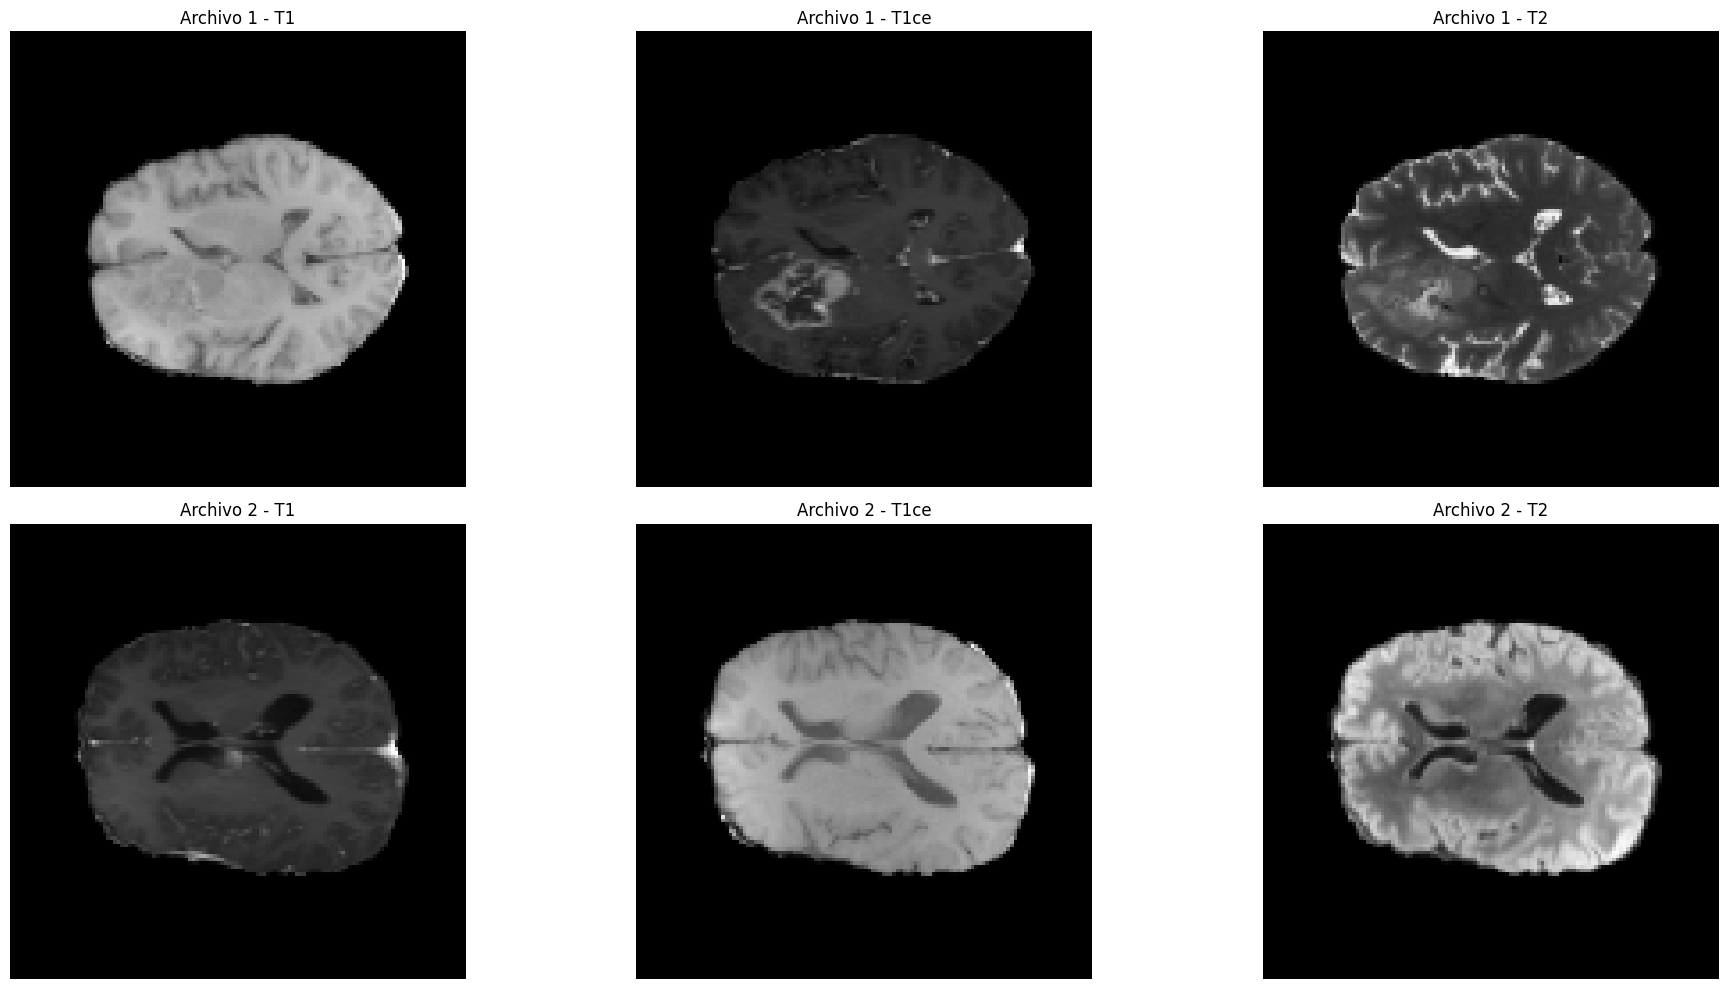

In [8]:

images_sequence1, masks_sequence1 = load_hdf5_file(file_path1)
images_sequence2, masks_sequence2 = load_hdf5_file(file_path2)

# Seleccionar una rebanada del eje z
z_slice = 64

# Comparar las imágenes y máscaras
print(f"Forma de las imágenes del primer archivo: {images_sequence1.shape}")
print(f"Forma de las imágenes del segundo archivo: {images_sequence2.shape}")
print(f"Forma de las máscaras del primer archivo: {masks_sequence1.shape}")
print(f"Forma de las máscaras del segundo archivo: {masks_sequence2.shape}")

# Asegúrate de que ambas imágenes tengan el mismo número de modalidades para una comparación justa
min_modalities = min(images_sequence1.shape[-1], images_sequence2.shape[-1])

# Crear un subplot de 2 filas y 2 columnas para comparar imágenes y máscaras
fig, axes = plt.subplots(2, min_modalities, figsize=(20, 10))
modalities = ['T1', 'T1ce', 'T2', 'FLAIR']

# Visualizar las modalidades de imagen en la primera fila
for i in range(min_modalities):
    axes[0, i].imshow(images_sequence1[:, :, z_slice, i], cmap='gray')
    axes[0, i].set_title(f'Archivo 1 - {modalities[i]}')
    axes[0, i].axis('off')

    axes[1, i].imshow(images_sequence2[:, :, z_slice, i], cmap='gray')
    axes[1, i].set_title(f'Archivo 2 - {modalities[i]}')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()


Forma de las imágenes del primer archivo: (128, 128, 128, 4)
Forma de las imágenes del segundo archivo: (128, 128, 128, 3)
Forma de las máscaras del primer archivo: (128, 128, 128, 4)
Forma de las máscaras del segundo archivo: (128, 128, 128, 4)


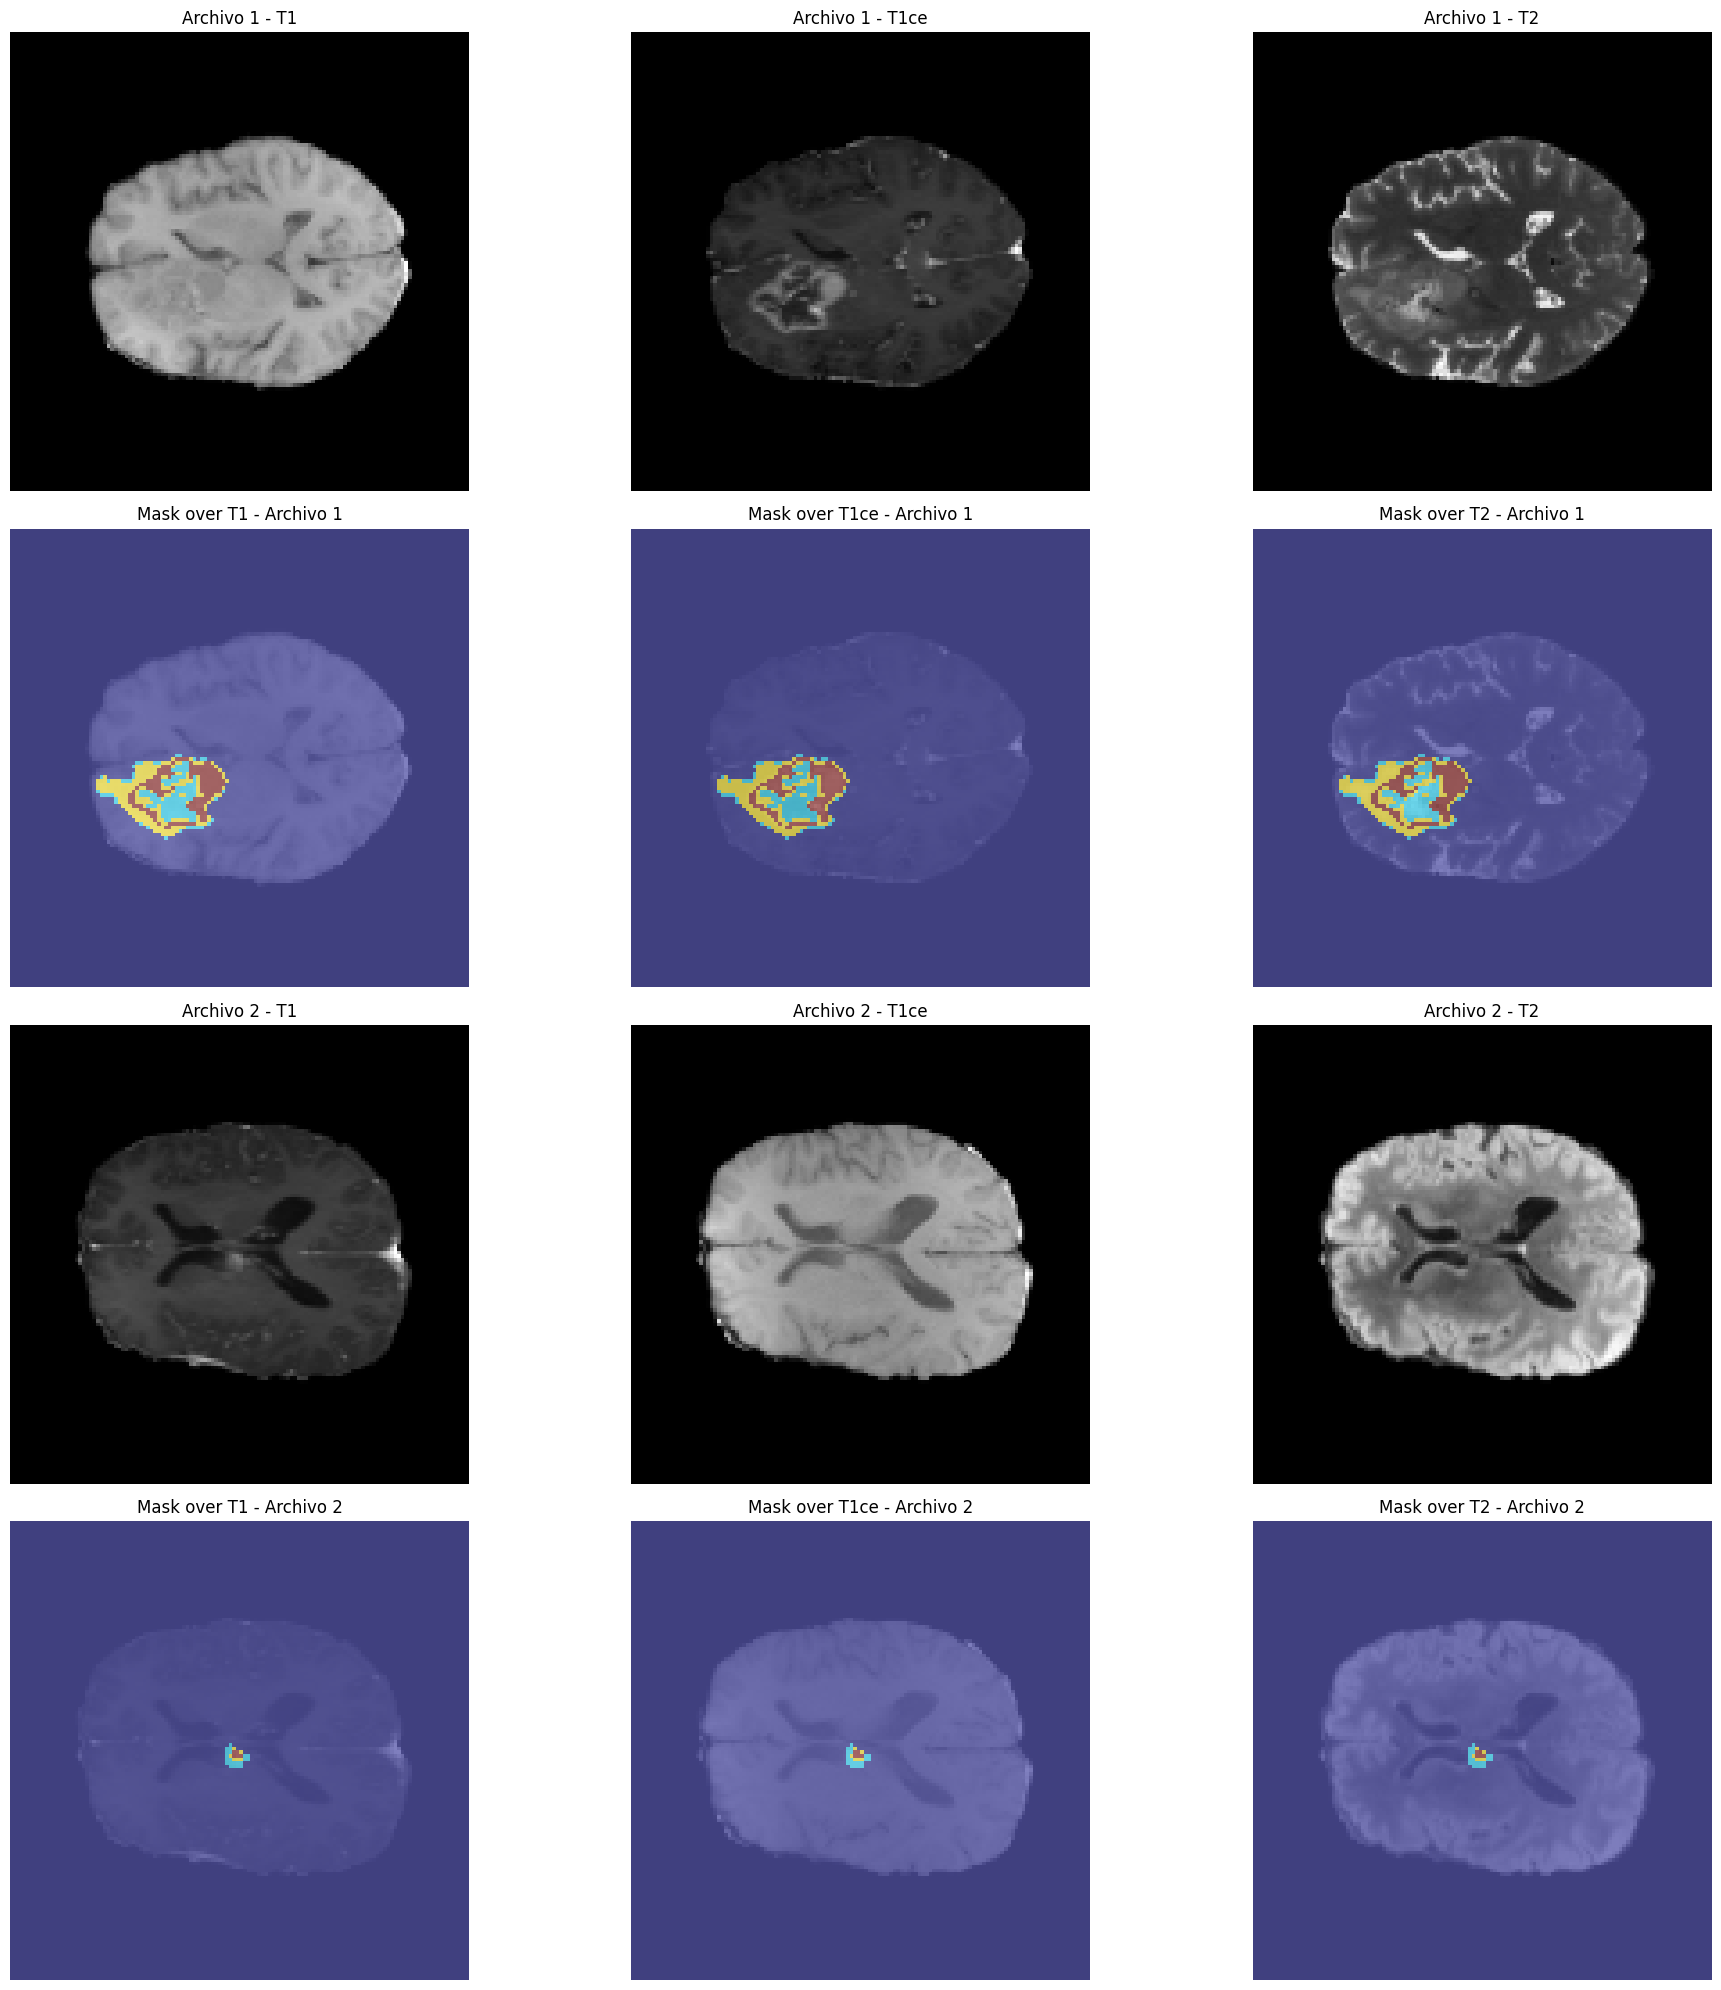

In [10]:

images_sequence1, masks_sequence1 = load_hdf5_file(file_path1)
images_sequence2, masks_sequence2 = load_hdf5_file(file_path2)

# Seleccionar una rebanada del eje z
z_slice = 64

# Comparar las imágenes y máscaras
print(f"Forma de las imágenes del primer archivo: {images_sequence1.shape}")
print(f"Forma de las imágenes del segundo archivo: {images_sequence2.shape}")
print(f"Forma de las máscaras del primer archivo: {masks_sequence1.shape}")
print(f"Forma de las máscaras del segundo archivo: {masks_sequence2.shape}")

# Asegúrate de que ambas imágenes tengan el mismo número de modalidades para una comparación justa
min_modalities = min(images_sequence1.shape[-1], images_sequence2.shape[-1])

# Crear un subplot de 4 filas y min_modalities columnas para comparar imágenes y máscaras
fig, axes = plt.subplots(4, min_modalities, figsize=(20, 20))
modalities = ['T1', 'T1ce', 'T2', 'FLAIR']

# Visualizar las modalidades de imagen en la primera y tercera filas
for i in range(min_modalities):
    axes[0, i].imshow(images_sequence1[:, :, z_slice, i], cmap='gray')
    axes[0, i].set_title(f'Archivo 1 - {modalities[i]}')
    axes[0, i].axis('off')

    axes[2, i].imshow(images_sequence2[:, :, z_slice, i], cmap='gray')
    axes[2, i].set_title(f'Archivo 2 - {modalities[i]}')
    axes[2, i].axis('off')

# Visualizar las máscaras correspondientes en la segunda y cuarta filas
combined_mask1 = np.argmax(masks_sequence1[:, :, z_slice, :], axis=-1)
combined_mask2 = np.argmax(masks_sequence2[:, :, z_slice, :], axis=-1)
for i in range(min_modalities):
    axes[1, i].imshow(images_sequence1[:, :, z_slice, i], cmap='gray', alpha=0.5)
    axes[1, i].imshow(combined_mask1, cmap='jet', alpha=0.5)
    axes[1, i].set_title(f'Mask over {modalities[i]} - Archivo 1')
    axes[1, i].axis('off')

    axes[3, i].imshow(images_sequence2[:, :, z_slice, i], cmap='gray', alpha=0.5)
    axes[3, i].imshow(combined_mask2, cmap='jet', alpha=0.5)
    axes[3, i].set_title(f'Mask over {modalities[i]} - Archivo 2')
    axes[3, i].axis('off')

plt.tight_layout()
plt.savefig('comparacion_imagenes_mascaras.png')
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\mnt\\data\\comparacion_imagenes_mascaras_detallada.png'

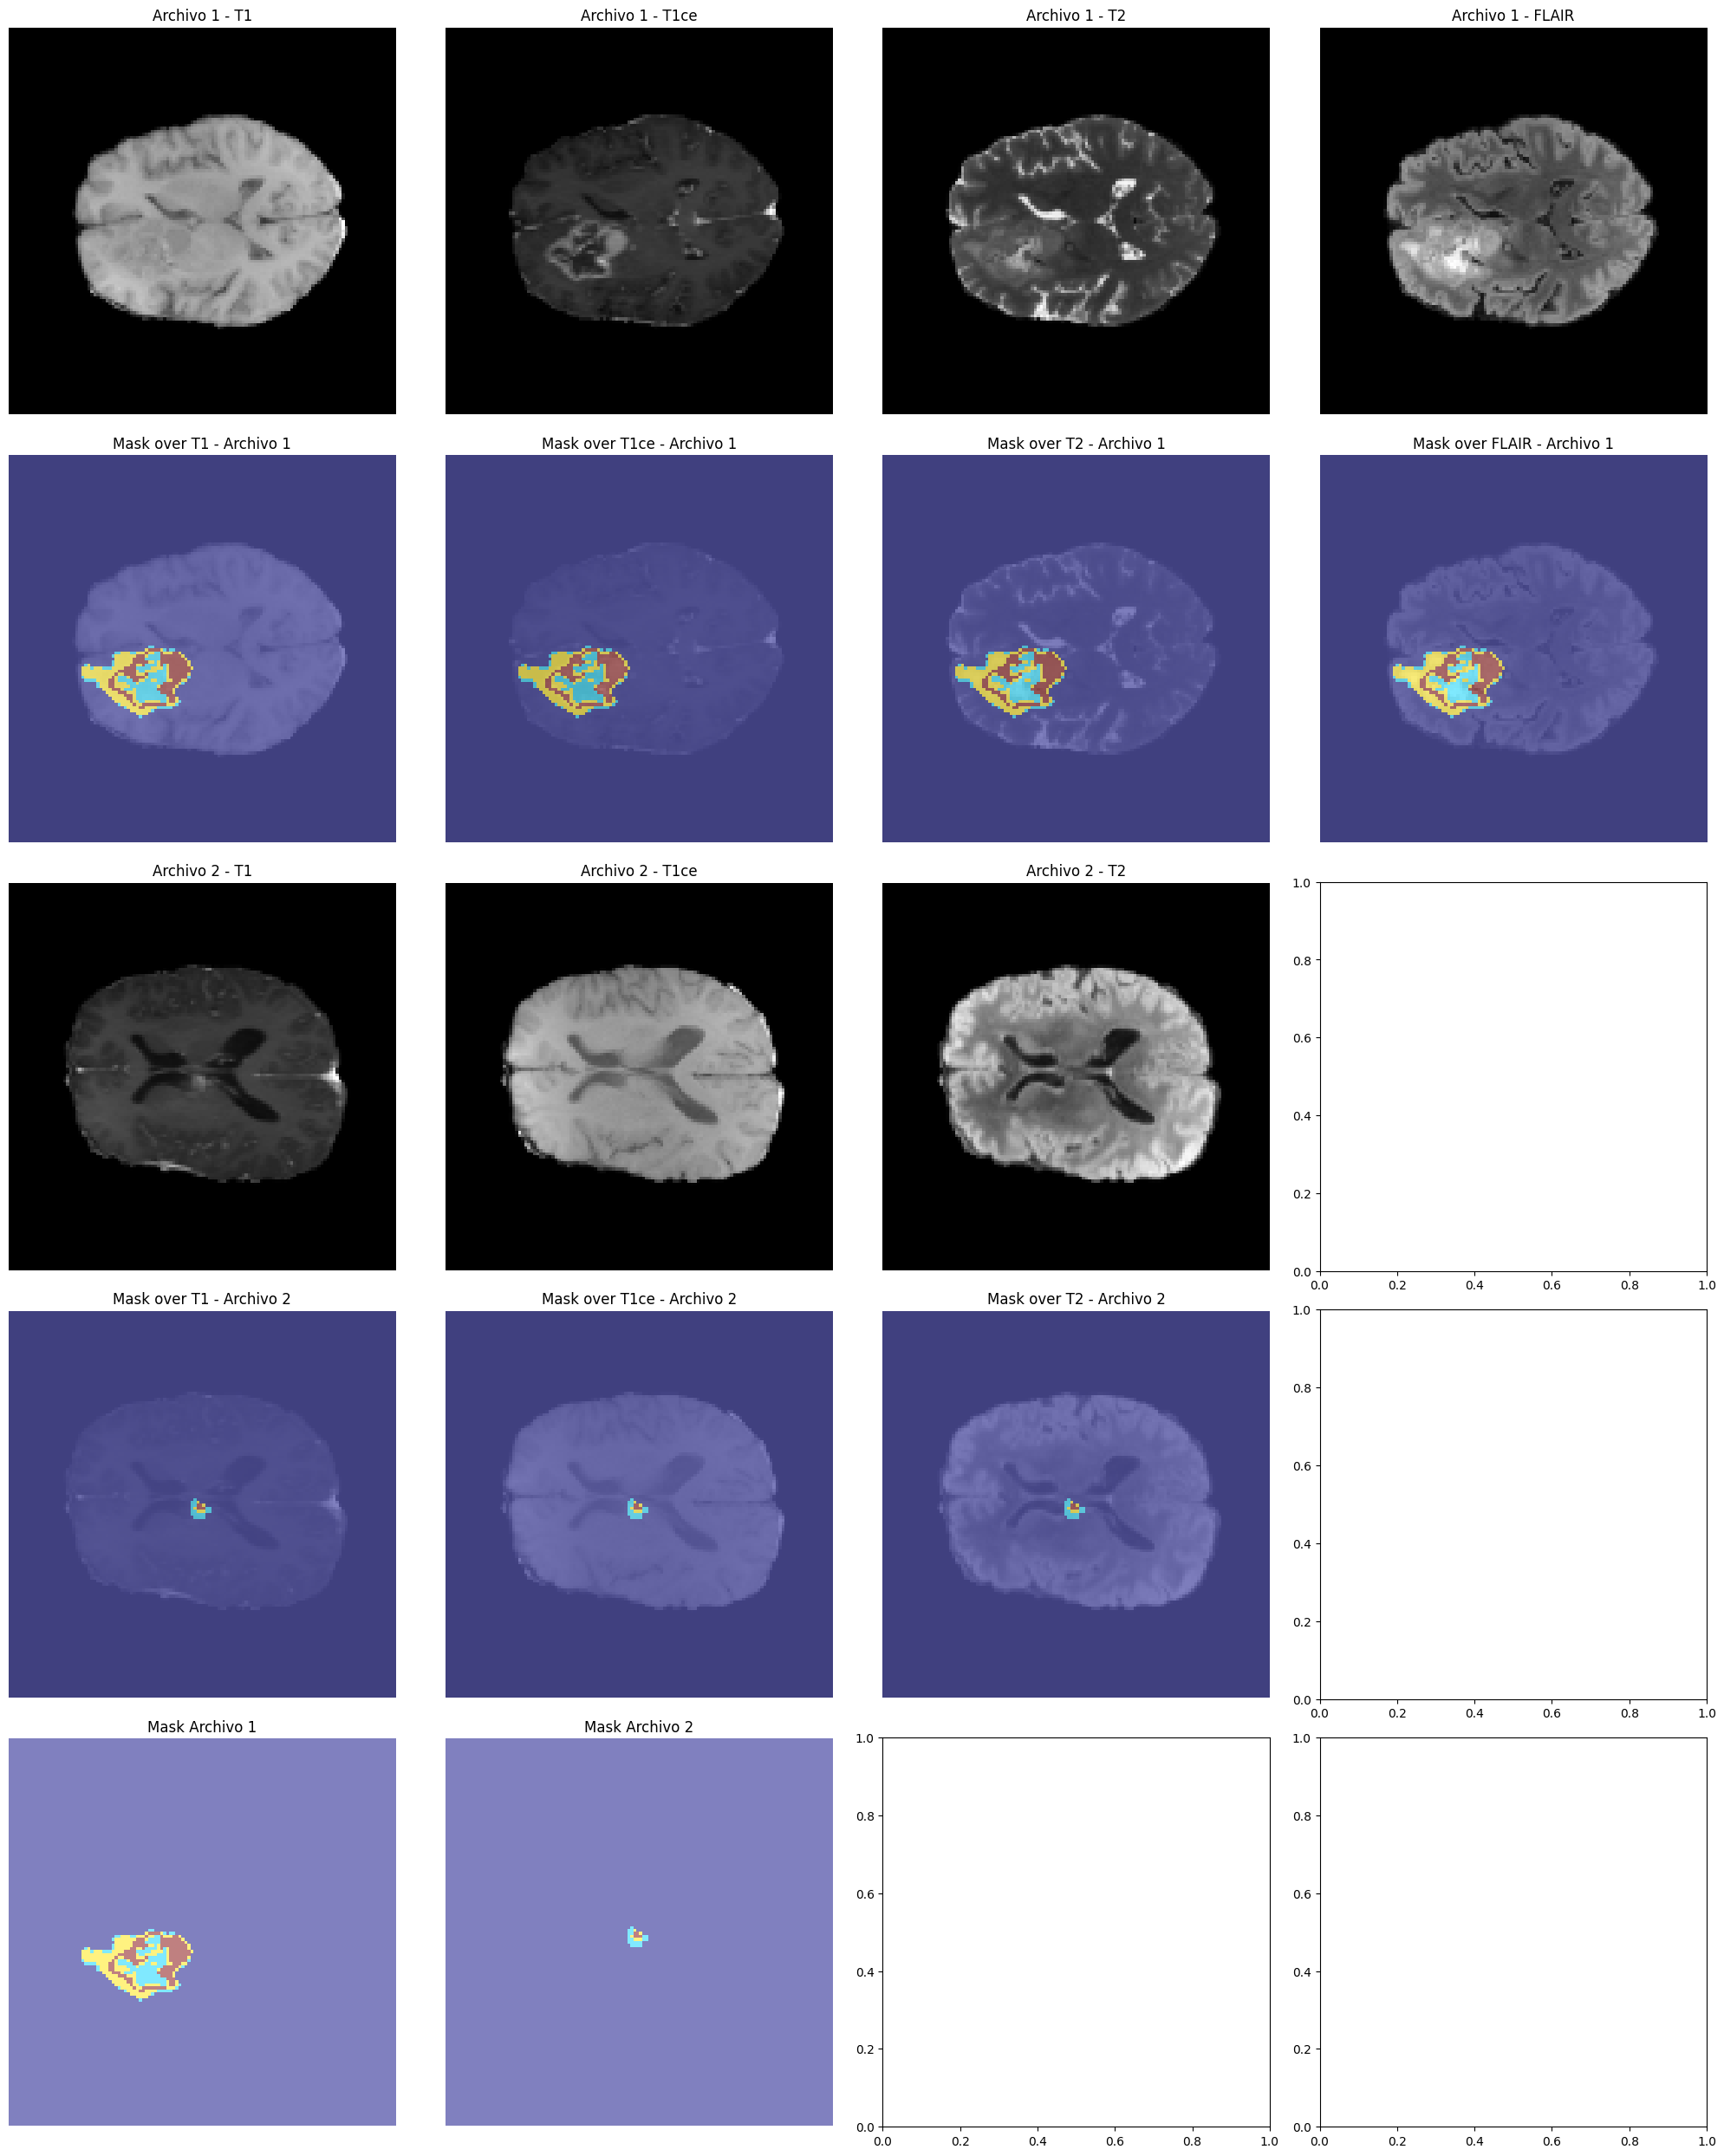

In [11]:

images_sequence1, masks_sequence1 = load_hdf5_file(file_path1)
images_sequence2, masks_sequence2 = load_hdf5_file(file_path2)

# Seleccionar una rebanada del eje z
z_slice = 64

# Crear un subplot de 4 filas y min_modalities columnas para comparar imágenes y máscaras
fig, axes = plt.subplots(5, 4, figsize=(20, 25))
modalities = ['T1', 'T1ce', 'T2', 'FLAIR']

# Visualizar las modalidades de imagen en las primeras filas
for i in range(4):
    if i < images_sequence1.shape[-1]:
        axes[0, i].imshow(images_sequence1[:, :, z_slice, i], cmap='gray')
        axes[0, i].set_title(f'Archivo 1 - {modalities[i]}')
        axes[0, i].axis('off')
    if i < images_sequence2.shape[-1]:
        axes[2, i].imshow(images_sequence2[:, :, z_slice, i], cmap='gray')
        axes[2, i].set_title(f'Archivo 2 - {modalities[i]}')
        axes[2, i].axis('off')

# Visualizar las máscaras correspondientes en las segundas filas
combined_mask1 = np.argmax(masks_sequence1[:, :, z_slice, :], axis=-1)
combined_mask2 = np.argmax(masks_sequence2[:, :, z_slice, :], axis=-1)
for i in range(4):
    if i < images_sequence1.shape[-1]:
        axes[1, i].imshow(images_sequence1[:, :, z_slice, i], cmap='gray', alpha=0.5)
        axes[1, i].imshow(combined_mask1, cmap='jet', alpha=0.5)
        axes[1, i].set_title(f'Mask over {modalities[i]} - Archivo 1')
        axes[1, i].axis('off')
    if i < images_sequence2.shape[-1]:
        axes[3, i].imshow(images_sequence2[:, :, z_slice, i], cmap='gray', alpha=0.5)
        axes[3, i].imshow(combined_mask2, cmap='jet', alpha=0.5)
        axes[3, i].set_title(f'Mask over {modalities[i]} - Archivo 2')
        axes[3, i].axis('off')

# Visualizar la diferencia de las máscaras
axes[4, 0].imshow(combined_mask1, cmap='jet', alpha=0.5)
axes[4, 0].set_title('Mask Archivo 1')
axes[4, 0].axis('off')

axes[4, 1].imshow(combined_mask2, cmap='jet', alpha=0.5)
axes[4, 1].set_title('Mask Archivo 2')
axes[4, 1].axis('off')

plt.tight_layout()
plt.savefig('/mnt/data/comparacion_imagenes_mascaras_detallada.png')
plt.show()


Forma de las imágenes del primer archivo: (128, 128, 128, 4)
Forma de las imágenes del segundo archivo: (128, 128, 128, 3)
Forma de la máscara de segmentación: (240, 240, 155)


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\mnt\\data\\comparacion_imagenes_mascaras.png'

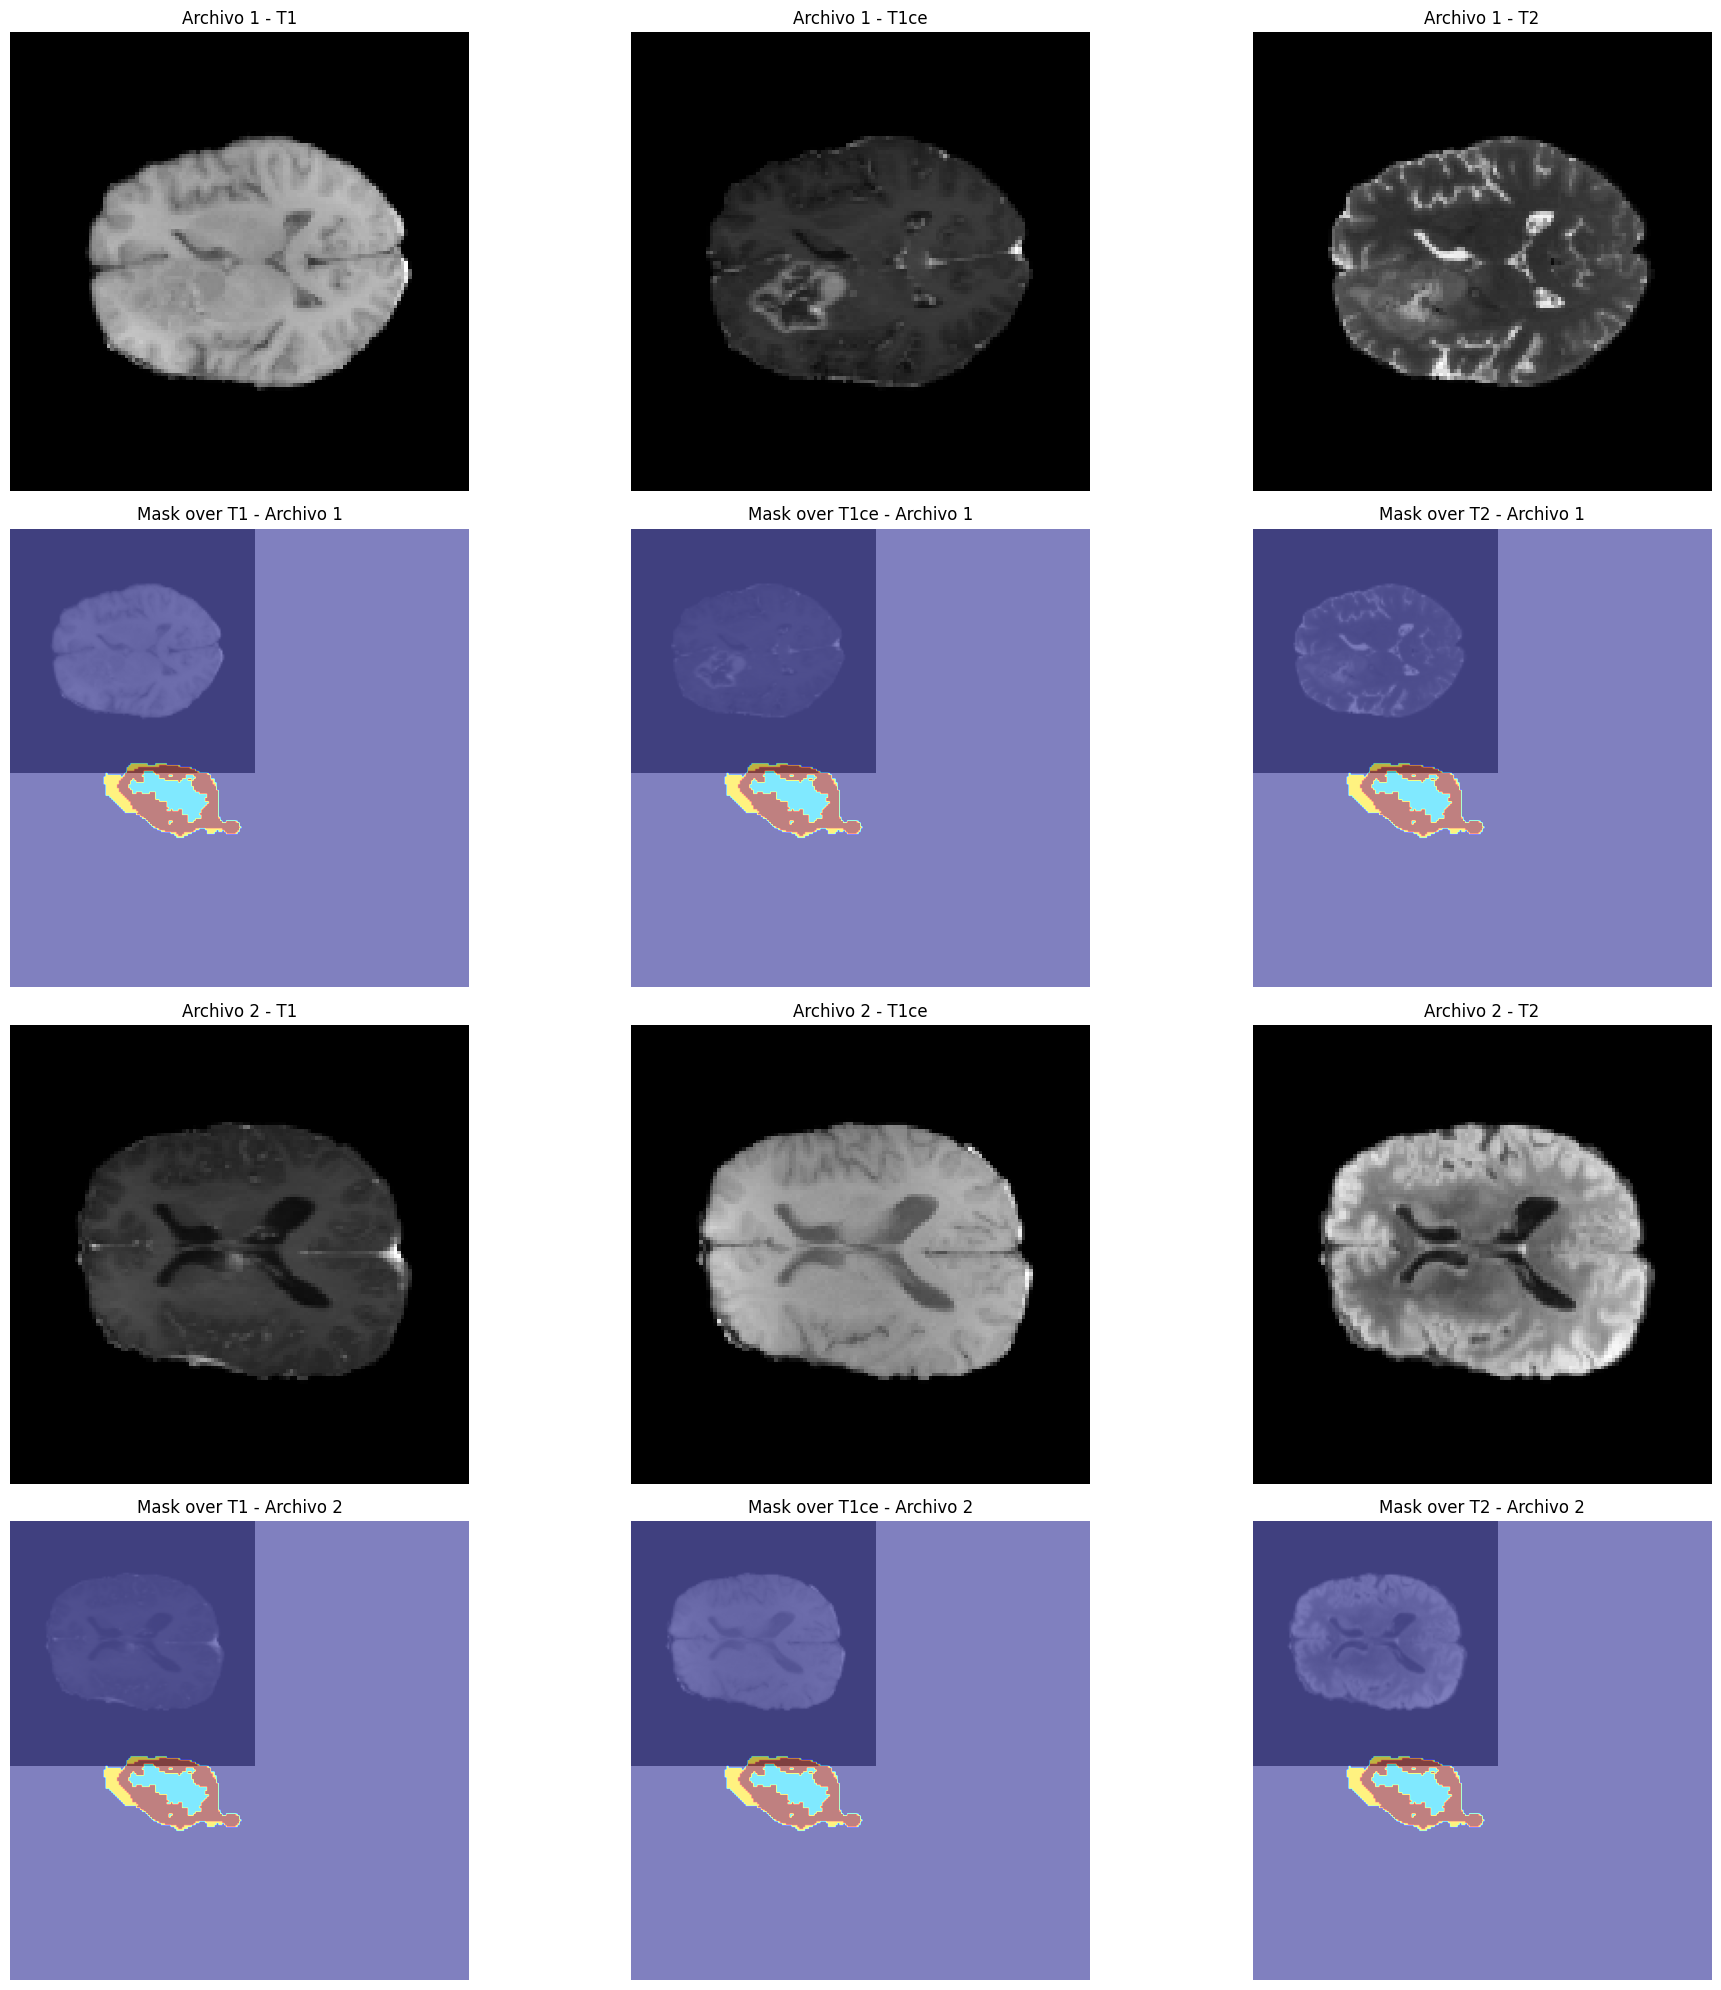

In [20]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import nibabel as nib

# Función para cargar datos de un archivo HDF5
def load_hdf5_file(file_path):
    with h5py.File(file_path, 'r') as hf:
        images_sequence = hf['images'][:]
    return images_sequence

# Función para cargar la máscara de un archivo NIfTI
def load_nifti_file(file_path):
    nii = nib.load(file_path)
    mask_sequence = nii.get_fdata()
    return mask_sequence

# Rutas de los archivos HDF5
file_path1 = 'D:/procesadaH5/patient_0.h5'  # Ruta del archivo utilizado en el primer código
file_path2 = 'C:/Users/lcres/Desktop/modelo/patient_0.h5'  # Ruta del archivo utilizado en el segundo código

# Ruta del archivo NIfTI para la segmentación
mask_file_path = 'C:/Users/lcres/Desktop/BraTS-GLI-00000-000/seg.nii.gz'  # Ruta del archivo de segmentación

# Cargar los datos de los archivos HDF5 y NIfTI
images_sequence1 = load_hdf5_file(file_path1)
images_sequence2 = load_hdf5_file(file_path2)
mask_sequence = load_nifti_file(mask_file_path)

# Seleccionar una rebanada del eje z
z_slice = 64

# Comparar las imágenes y máscaras
print(f"Forma de las imágenes del primer archivo: {images_sequence1.shape}")
print(f"Forma de las imágenes del segundo archivo: {images_sequence2.shape}")
print(f"Forma de la máscara de segmentación: {mask_sequence.shape}")

# Asegúrate de que ambas imágenes tengan el mismo número de modalidades para una comparación justa
min_modalities = min(images_sequence1.shape[-1], images_sequence2.shape[-1])

# Crear un subplot de 4 filas y min_modalities columnas para comparar imágenes y máscaras
fig, axes = plt.subplots(4, min_modalities, figsize=(20, 20))
modalities = ['T1', 'T1ce', 'T2', 'FLAIR']

# Visualizar las modalidades de imagen en las primeras filas
for i in range(min_modalities):
    if i < images_sequence1.shape[-1]:
        axes[0, i].imshow(images_sequence1[:, :, z_slice, i], cmap='gray')
        axes[0, i].set_title(f'Archivo 1 - {modalities[i]}')
        axes[0, i].axis('off')
    if i < images_sequence2.shape[-1]:
        axes[2, i].imshow(images_sequence2[:, :, z_slice, i], cmap='gray')
        axes[2, i].set_title(f'Archivo 2 - {modalities[i]}')
        axes[2, i].axis('off')

# Visualizar las máscaras correspondientes en las segundas filas
for i in range(min_modalities):
    if i < images_sequence1.shape[-1]:
        axes[1, i].imshow(images_sequence1[:, :, z_slice, i], cmap='gray', alpha=0.5)
        axes[1, i].imshow(mask_sequence[:, :, z_slice], cmap='jet', alpha=0.5)
        axes[1, i].set_title(f'Mask over {modalities[i]} - Archivo 1')
        axes[1, i].axis('off')
    if i < images_sequence2.shape[-1]:
        axes[3, i].imshow(images_sequence2[:, :, z_slice, i], cmap='gray', alpha=0.5)
        axes[3, i].imshow(mask_sequence[:, :, z_slice], cmap='jet', alpha=0.5)
        axes[3, i].set_title(f'Mask over {modalities[i]} - Archivo 2')
        axes[3, i].axis('off')

plt.tight_layout()
plt.savefig('/mnt/data/comparacion_imagenes_mascaras.png')
plt.show()


Forma original de la máscara de segmentación: (240, 240, 155)


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\mnt\\data\\segmentacion_nii.png'

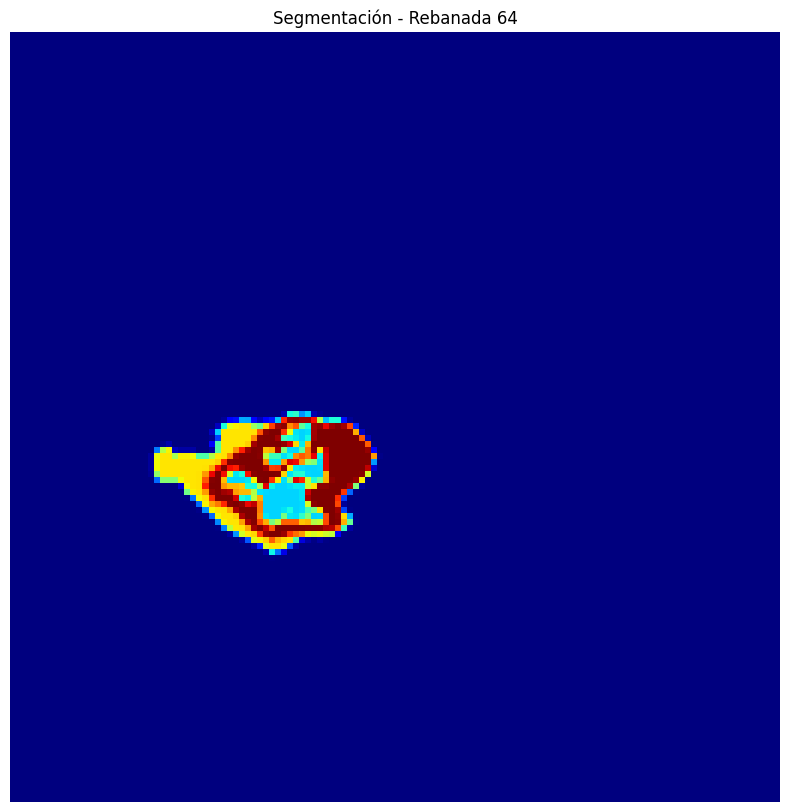

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
from skimage.transform import resize

# Función para cargar la máscara de un archivo NIfTI
def load_nifti_file(file_path):
    nii = nib.load(file_path)
    mask_sequence = nii.get_fdata()
    return mask_sequence

# Ruta del archivo NIfTI para la segmentación
mask_file_path = 'C:/Users/lcres/Desktop/BraTS-GLI-00000-000/seg.nii.gz'  # Ruta del archivo de segmentación

# Cargar la máscara de segmentación
mask_sequence = load_nifti_file(mask_file_path)

# Imprimir la forma original de la máscara
print(f"Forma original de la máscara de segmentación: {mask_sequence.shape}")

# Redimensionar la máscara a (128, 128, 128)
mask_resized = resize(mask_sequence, (128, 128, 128), mode='constant', preserve_range=True)

# Seleccionar una rebanada del eje z
z_slice = 64

# Visualizar la máscara de segmentación redimensionada
plt.figure(figsize=(10, 10))
plt.imshow(mask_resized[:, :, z_slice], cmap='jet')
plt.title(f'Segmentación - Rebanada {z_slice}')
plt.axis('off')

# Guardar la visualización
plt.savefig('/mnt/data/segmentacion_nii.png')
plt.show()


In [ ]:
import numpy as np
import nibabel as nib
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.utils import to_categorical
from skimage.transform import resize
import h5py
import glob
import os

################################# TRANSFORMACIÓN-FORMATO REQUERIDO PARA LA PREDICCIÓN ############################################
# Define el directorio general que contiene la data original de cada paciente
main_path = '/content/drive/MyDrive/dataValidation2023/BraTS-GLI-00001-000/'  # Cambia esto al path del paciente

# Define el directorio para la data preprocesada
pathPreprocesada = '/content/drive/MyDrive/dataValidation2023/validacionh5/'

# Lista de archivos para el paciente específico
t1ce_list = sorted(glob.glob(os.path.join(main_path, '*t1c.nii.gz')))
flair_list = sorted(glob.glob(os.path.join(main_path, '*t2f.nii.gz')))
t1_list = sorted(glob.glob(os.path.join(main_path, '*t1n.nii.gz')))
t2_list = sorted(glob.glob(os.path.join(main_path, '*t2w.nii.gz')))
# Eliminamos la lista de máscaras
# mask_list = sorted(glob.glob(os.path.join(main_path, '*seg.nii.gz')))

# Asegúrate de que haya imágenes para procesar
if not (t1ce_list and flair_list):
    print(f"No se encontraron archivos para el path especificado.")
else:
    scaler = MinMaxScaler()
    target_shape = (128, 128, 128)  # Dimensiones objetivo

    for img in range(len(t1ce_list)):  # Usando t1ce_list ya que todas las listas tienen el mismo tamaño
        print("Now preparing image number: ", img)
        temp_image_t1 = nib.load(t1_list[img]).get_fdata()
        temp_image_t1 = scaler.fit_transform(temp_image_t1.reshape(-1, temp_image_t1.shape[-1])).reshape(temp_image_t1.shape)
        temp_image_t2 = nib.load(t2_list[img]).get_fdata()
        temp_image_t2 = scaler.fit_transform(temp_image_t2.reshape(-1, temp_image_t2.shape[-1])).reshape(temp_image_t2.shape)

        # Cargar y normalizar imágenes
        temp_image_t1ce = nib.load(t1ce_list[img]).get_fdata()
        temp_image_t1ce = scaler.fit_transform(temp_image_t1ce.reshape(-1, temp_image_t1ce.shape[-1])).reshape(temp_image_t1ce.shape)

        temp_image_flair = nib.load(flair_list[img]).get_fdata()
        temp_image_flair = scaler.fit_transform(temp_image_flair.reshape(-1, temp_image_flair.shape[-1])).reshape(temp_image_flair.shape)

        # Combinar imágenes
        temp_combined_images = np.stack([temp_image_t1,temp_image_t1ce,temp_image_t2, temp_image_flair], axis=3)

        # Redimensionar a las dimensiones deseadas
        temp_combined_images_resized = resize(temp_combined_images, target_shape, mode='constant', anti_aliasing=True)

        # Guardar en un único archivo HDF5
        with h5py.File(os.path.join(pathPreprocesada, f'patient_{os.path.basename(main_path)}_{img}_2M.h5'), 'w') as hf:
            hf.create_dataset('images', data=temp_combined_images_resized, compression='gzip')

        print(f"Imágenes guardadas con path del paciente {os.path.basename(main_path)} como HDF5.")
